In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

### HDF5 Stuff

In [2]:
geant4_name = "../GSGM.h5"
label = "GSGM"
f = h5py.File(geant4_name, 'r')
f.keys()
dataset = "cell_features"
#dataset = "hcal_cells"
chunk_size=2000

print("[E, X, Y, Z]")
for i in range(5):
    print(f[dataset][1,i,:]) #XYZ, skip mask
    
print(np.shape(f[dataset]))

[E, X, Y, Z]
[-2.98126270e+00 -6.00992095e+02  1.32202226e+03  3.94403663e+03]
[-1.79263702e+00 -7.13561813e+02  1.33014865e+03  3.89524666e+03]
[-2.98692550e+00 -5.50084654e+02  1.50890511e+03  3.93569367e+03]
[-2.43387331e+00 -4.64664614e+02  1.44736520e+03  4.02698156e+03]
[-3.23401809e+00 -6.23526586e+02  1.35737941e+03  3.91077649e+03]
(100000, 200, 4)


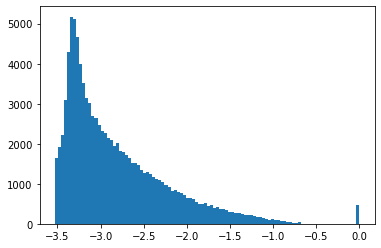

In [3]:
energy = f[dataset][:,i,0]
_ = plt.hist(np.ravel(energy),bins=100)

In [4]:
h5_indexE = 0
h5_indexX = 1
h5_indexY = 2
h5_indexZ = 3

### Detector Parameters XYZ

In [5]:
voxel_factor=5

minXY = -2700
maxXY = 2700
widthXY = 100
ncellsXY = int(((maxXY-minXY)/widthXY)/voxel_factor)
binningXY = np.linspace(minXY,maxXY,ncellsXY+1)

minZ = 3820
maxZ = 4991
widthZ = 23.4
ncellsZ = int((((maxZ-minZ)/widthZ)+3)/voxel_factor)
binningZ = np.linspace(minZ,maxZ,ncellsZ+1)
print(ncellsZ)

n_truth_features = 2

10


## CaloScore takes [N,Z,X,Y] images. Our HDF5 files have [N,X,Y,Z]. Swap Z with X, and then X with Y

In [6]:
from tqdm import tqdm
nevents = np.shape(f[dataset])[0]
with h5py.File(f'{label}_hcal_images_{voxel_factor}x{voxel_factor}.h5', 'w') as newfile:
    # create empty data set
    dset = newfile.create_dataset('calo_images', shape=(nevents, ncellsZ, ncellsXY, ncellsXY),
                            maxshape=(None, ncellsZ, ncellsXY, ncellsXY), chunks=(chunk_size, ncellsZ, ncellsXY, ncellsXY),
                            dtype=np.float32)
    truth_dset = newfile.create_dataset('truth_features', shape=(nevents, n_truth_features),
                            maxshape=(None, n_truth_features), chunks=(chunk_size, n_truth_features),
                            dtype=np.float32)
    
    for chunk in tqdm(range(int(nevents/chunk_size))):
    #for chunk in range(10):
        # add chunk of rows
        start = chunk*chunk_size
        #print(start)
        data = f[dataset][start:start+chunk_size]
        data[:,:,[1,3]] = data[:,:,[3,1]]#Z-Data is now at X-index, and X-Data is at previous Z-index
        data[:,:,[2,3]] = data[:,:,[3,2]]
        
        if dataset=="cell_features":
            truth = f['cluster_features'][start:start+chunk_size,1] #genTheta, genP
        else:
            truth = f['cluster'][start:start+chunk_size,0:2] #genP, genTheta
        
        images = []
        for evt in range(chunk_size):
            counts, binedges = np.histogramdd(data[evt,:,:-2], bins=(ncellsZ,ncellsXY,ncellsZ), weights=data[evt,:,h5_indexE])
            images.append(counts)
        images=np.asarray(images)
        
        dset[start:start+chunk_size, :, :,:] = images[:, :, :,:]
        truth_dset[start:start+chunk_size, :] = truth[:,:]

  0%|          | 0/50 [00:00<?, ?it/s]


KeyError: "Unable to open object (object 'cluster_features' doesn't exist)"

In [ ]:
with h5py.File('epic_hcal_images_5x5.h5', 'r') as newfile:
    #print(f['calo_images'].attrs['last_index'])
    print(newfile['calo_images'].shape)
    #print(f['embeds'][0:26])
    #print(newfile['calo_images'][0])
    for i in range(13):
        for row in newfile['calo_images'][0,:,:,i]:
            print(row)